In [33]:
import os

import lightning as L
from lightning.pytorch.loggers import CSVLogger
import pandas as pd
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
from torchmetrics import Accuracy
from torchvision import transforms

from torchvision.datasets import MNIST

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE = 256 if torch.cuda.is_available() else 64

In [34]:
class MNISTModel(L.LightningModule):
    def __init__(self, data_dir=PATH_DATASETS, hidden_size=64, learning_rate=2e-4):
        super().__init__()
        
        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        
        self.num_classes = 10
        self.dims = (1, 28, 28)
        channels, width, height = self.dims
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )
        
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels * width * height, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, self.num_classes),
        )
        
        self.l1 = torch.nn.Linear(28 * 28, 10)
        
        self.val_accuracy = Accuracy(task="multiclass", num_classes=10)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_nb):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)
    
    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=BATCH_SIZE)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=BATCH_SIZE)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=BATCH_SIZE)

In [35]:
model = MNISTModel()
trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=10,
    logger=CSVLogger(save_dir="logs/"),
)
trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | Sequential         | 55.1 K
1 | l1            | Linear             | 7.9 K 
2 | val_accuracy  | MulticlassAccuracy | 0     
3 | test_accuracy | MulticlassAccuracy | 0     
-----------------------------------------------------
62.9 K    Trainable params
0         Non-trainable params
62.9 K    Total params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\cooki\anaconda3\envs\co-op\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


C:\Users\cooki\anaconda3\envs\co-op\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 215/215 [00:10<00:00, 19.80it/s, v_num=1, val_loss=0.145, val_acc=0.954]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 215/215 [00:10<00:00, 19.78it/s, v_num=1, val_loss=0.145, val_acc=0.954]


In [39]:
trainer.test()

C:\Users\cooki\anaconda3\envs\co-op\lib\site-packages\lightning\pytorch\trainer\connectors\checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at logs/lightning_logs\version_1\checkpoints\epoch=9-step=2150.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs/

Testing DataLoader 0: 100%|██████████| 40/40 [00:01<00:00, 24.67it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9584000110626221     │
│         test_loss         │    0.13750988245010376    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.13750988245010376, 'test_acc': 0.9584000110626221}]

In [31]:
trainer.fit(model)

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
C:\Users\cooki\anaconda3\envs\co-op\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:615: UserWarning: Checkpoint directory logs/lightning_logs\version_0\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | Sequential         | 55.1 K
1 | l1            | Linear             | 7.9 K 
2 | val_accuracy  | MulticlassAccuracy | 0     
3 | test_accuracy | MulticlassAccuracy | 0     
---

`Trainer.fit` stopped: `max_epochs=10` reached.


,val_loss,val_acc,test_loss,test_acc
epoch,,,,
0,0.441773,0.8782,NaN,NaN
1,0.314273,0.9050,NaN,NaN
2,0.266917,0.9204,NaN,NaN
3,0.234619,0.9316,NaN,NaN
4,0.210164,0.9374,NaN,NaN


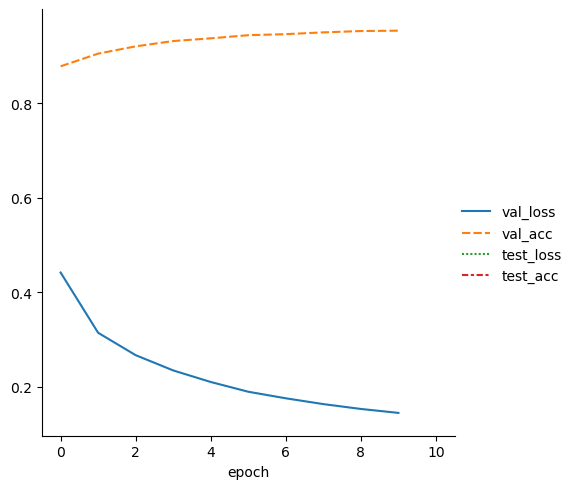

In [45]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")